<a href="https://colab.research.google.com/github/ryu622/gnn-counterattack-xai-v2/blob/feat%2Fnew-file/GAT_CounterAttack_Prediction_Train_Scientific9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#シード値
import random
import os
import numpy as np
import torch

def set_seed(seed=42):
    # Python自体の乱数固定
    random.seed(seed)
    # OS環境の乱数固定
    os.environ['PYTHONHASHSEED'] = str(seed)
    # Numpyの乱数固定
    np.random.seed(seed)
    # PyTorchの乱数固定
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # マルチGPUの場合
    # 計算の決定論的挙動を強制（これを入れると少し遅くなることがありますが、再現性は完璧になります）
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 好きな数字（42が一般的）で固定
set_seed(44)

In [ ]:
# --- 1. 環境設定と依存関係のインストール ---
# 必要なライブラリをすべてインストール
!pip install torch-scatter torch-sparse torch-geometric sklearn tqdm networkx matplotlib
!pip install torch-geometric

# Google Driveをマウント（ファイルアクセスに必須）
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader as PyGDataLoader
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.utils import dense_to_sparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.calibration import calibration_curve
from tqdm import tqdm
import numpy as np
import pickle
import sys
import networkx as nx
import matplotlib.pyplot as plt
import os
import logging
import copy

# ロガー設定
logger = logging.getLogger(__name__)
if not logger.handlers:
    stdout_handler = logging.StreamHandler(sys.stdout)
    logger.addHandler(stdout_handler)

print("✅ STEP 1 完了: 環境設定と依存関係のインポートが完了しました。")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 5.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Using cached torch_geometric-2.7.0-py3-none-any.whl.metadata (63 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.4 MB/s eta 0:00:00
Mounted at /content/drive
✅ STEP 1 完了: 環境設定

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_geometric.utils import softmax


class PIGNNLayer(MessagePassing):
    def __init__(self, in_channels, out_channels, tau=0.20):
        super(PIGNNLayer, self).__init__(aggr='add')
        self.tau = tau
        self.lin = nn.Linear(in_channels, out_channels)
        self.att = nn.Parameter(torch.Tensor(1, out_channels * 2))
        nn.init.xavier_uniform_(self.att)
        self.last_alpha = None

    # forwardの引数を (x, edge_index, pos, prev_pos, pprev_pos) の5つにする
    def forward(self, x, edge_index, pos, prev_pos, pprev_pos):
        h = self.lin(x)
        # 必要な情報をすべて propagate に渡す
        return self.propagate(edge_index, x=h, pos=pos, prev_pos=prev_pos, pprev_pos=pprev_pos)

    # message関数の引数名は、propagateで渡した名前 (x, pos, ...) に _i や _j をつけたもの
    def message(self, x_i, x_j, pos_j, prev_pos_j, pprev_pos_j, edge_index_i):
        # 物理予測
        calc_prev_vel_j = (prev_pos_j - pprev_pos_j) / self.tau
        expected_curr_pos_j = prev_pos_j + calc_prev_vel_j * self.tau
        residual = torch.norm(pos_j - expected_curr_pos_j, dim=-1, keepdim=True)

        # 物理ゲート
        gate_steepness = 50.0
        threshold = 0.05
        reliability_gate = torch.sigmoid(gate_steepness * (threshold - residual))

        # アテンション
        alpha = torch.cat([x_i, x_j], dim=-1)
        alpha = (alpha * self.att).sum(dim=-1, keepdim=True)
        alpha = F.leaky_relu(alpha) + torch.log(reliability_gate + 1e-9)
        alpha = softmax(alpha, edge_index_i)

        self.last_alpha = alpha.detach()
        return alpha * x_j


class PIGNNClassifier(nn.Module):
    def __init__(self, in_channels=7, hidden_channels=64):
        super(PIGNNClassifier, self).__init__()
        self.conv1 = PIGNNLayer(in_channels, hidden_channels)
        self.conv2 = PIGNNLayer(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, 2)

    def forward(self, data):
        # Dataオブジェクトから必要な属性を抽出
        x, edge_index, batch = data.x, data.edge_index, data.batch
        pos, prev_pos, pprev_pos = data.pos, data.prev_pos, data.pprev_pos

        x = F.elu(self.conv1(x, edge_index, pos, prev_pos, pprev_pos))
        x = F.elu(self.conv2(x, edge_index, pos, prev_pos, pprev_pos))

        x_pool = global_mean_pool(x, batch)
        return F.log_softmax(self.lin(x_pool), dim=1)

In [ ]:
def train_pignn_epoch_simple(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    # 重み付きNLLLossのみを使用（alpha_pは使わない）
    weights = torch.tensor([1.0, 3.3], device=device)

    for data in loader:
        data = preprocess_batch(data, device)
        optimizer.zero_grad()

        out = model(data)
        # 物理ゲートが計算に含まれているため、単純な分類損失で「物理」が学習される
        loss = F.nll_loss(out, data.y.view(-1), weight=weights)

        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

In [ ]:
import random

def balance_dataset_by_undersampling(data_list):
    """
    成功(y=1)と失敗(y=0)のデータを1:1の割合に調整する関数
    """
    success_data = [d for d in data_list if d.y.item() == 1]
    failure_data = [d for d in data_list if d.y.item() == 0]

    n_success = len(success_data)
    n_failure = len(failure_data)

    # 少ない方のクラスの数に合わせて、多い方のクラスをランダムサンプリング
    if n_success < n_failure:
        # 成功が少ない場合、失敗を減らす
        sampled_failure = random.sample(failure_data, n_success)
        balanced_list = success_data + sampled_failure
    else:
        # 失敗が少ない場合、成功を減らす
        sampled_success = random.sample(success_data, n_failure)
        balanced_list = failure_data + sampled_success

    random.shuffle(balanced_list)
    print(f"  >> アンダーサンプリング完了: 成功 {min(n_success, n_failure)}件 / 失敗 {min(n_success, n_failure)}件")
    return balanced_list

CV用マスターデータをロード中: /content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/gnn_data_v18_final.pt
検出された試合ID: [1, 2, 3, 4, 5, 6, 7] (計 7 試合)
🚀 PIGNN クロスバリデーション開始 (物理整合性ゲート・構造制約モード)


 🌀 Round: Match 1 をテストに使用
  >> アンダーサンプリング完了: 成功 182件 / 失敗 182件
  Epoch 01 | Loss: 0.6852
  Epoch 10 | Loss: 0.6066
  Epoch 20 | Loss: 0.5380
  Epoch 30 | Loss: 0.4844
  Epoch 40 | Loss: 0.4474
  Epoch 50 | Loss: 0.4363
  Epoch 60 | Loss: 0.4163
  Epoch 70 | Loss: 0.4217
  Epoch 80 | Loss: 0.4104
  Epoch 90 | Loss: 0.3980
  Epoch 100 | Loss: 0.3916
 ✨ New Best Model! F1=0.2923

 🌀 Round: Match 2 をテストに使用
  >> アンダーサンプリング完了: 成功 234件 / 失敗 234件
  Epoch 01 | Loss: 0.6868
  Epoch 10 | Loss: 0.6056
  Epoch 20 | Loss: 0.5815
  Epoch 30 | Loss: 0.5534
  Epoch 40 | Loss: 0.5135
  Epoch 50 | Loss: 0.4711
  Epoch 60 | Loss: 0.4255
  Epoch 70 | Loss: 0.4096
  Epoch 80 | Loss: 0.3849
  Epoch 90 | Loss: 0.3900
  Epoch 100 | Loss: 0.3794
 ✨ New Best Model! F1=0.3758

 🌀 Round: Match 3 をテストに使用
  >> アンダーサンプリング完了: 成功 244件 / 失敗

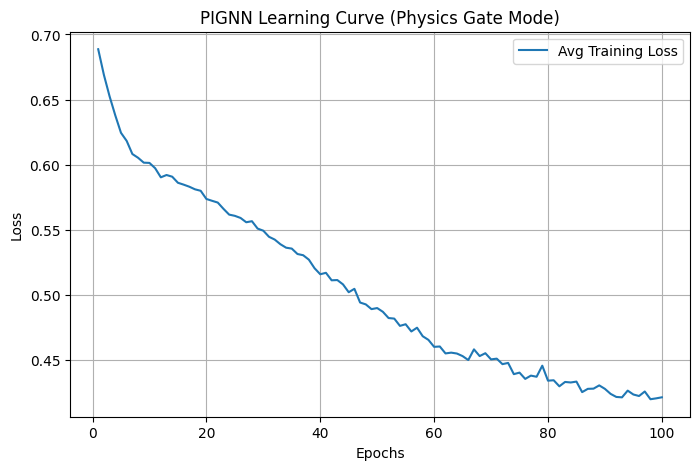

In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
from torch_geometric.loader import DataLoader
from sklearn.metrics import classification_report

# 1. デバイス準備
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- 【重要】物理ゲートモデルでは FIXED_ALPHA (損失への加算) は不要です ---
# もし以前との比較用に残したい場合以外は、シンプルな学習ループに切り替えます。

# 2. データのロード
v17_load_path = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/gnn_data_v18_final.pt"
print(f"CV用マスターデータをロード中: {v17_load_path}")
checkpoint = torch.load(v17_load_path, weights_only=False)
all_data_list = checkpoint['all_data']

# 試合IDの取得 (Dataオブジェクト内の match_id を参照)
match_ids = sorted(list(set([int(d.match_id.item()) for d in all_data_list])))
print(f"検出された試合ID: {match_ids} (計 {len(match_ids)} 試合)")

# ハイパーパラメータ
EPOCHS_CV = 100
LR = 0.0005
cv_final_reports = []
best_overall_f1 = 0
all_cv_history = []

print(f"🚀 PIGNN クロスバリデーション開始 (物理整合性ゲート・構造制約モード)\n")

for test_match in match_ids:
    print(f"\n{'='*60}")
    print(f" 🌀 Round: Match {test_match} をテストに使用")
    print(f"{'='*60}")

    # 1. データの切り分け
    test_indices = [d for d in all_data_list if int(d.match_id.item()) == test_match]
    train_candidates = [d for d in all_data_list if int(d.match_id.item()) != test_match]

    # 2. 訓練データのみ1:1アンダーサンプリング (外部関数を呼び出し)
    cv_train_set = balance_dataset_by_undersampling(train_candidates)

    cv_train_loader = DataLoader(cv_train_set, batch_size=32, shuffle=True)
    cv_test_loader = DataLoader(test_indices, batch_size=32, shuffle=False)

    # 3. モデル・最適化手法の初期化 (in_channels=7 に注意)
    cv_model = PIGNNClassifier(in_channels=7, hidden_channels=64).to(device)
    cv_optimizer = torch.optim.Adam(cv_model.parameters(), lr=LR)

    # 不均衡データ対策の重み (Failure:Success = 1:3.3)
    weights = torch.tensor([1.0, 1.0]).to(device)
    criterion = torch.nn.NLLLoss(weight=weights)

    round_history = {'total_loss': []}

    # 4. 学習ループ
    for epoch in range(1, EPOCHS_CV + 1):
        cv_model.train()
        total_loss = 0

        for batch in cv_train_loader:
            batch = batch.to(device)
            cv_optimizer.zero_grad()

            # 推論 (物理ゲートはモデル内部で自動作動)
            out = cv_model(batch)

            # 純粋な分類損失のみ
            loss = criterion(out, batch.y.view(-1))

            loss.backward()
            cv_optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(cv_train_loader)
        round_history['total_loss'].append(avg_loss)

        if epoch % 10 == 0 or epoch == 1:
            print(f"  Epoch {epoch:02d} | Loss: {avg_loss:.4f}")

    all_cv_history.append(round_history)

    # 5. 評価
    cv_model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for data in cv_test_loader:
            data = data.to(device)
            out = cv_model(data)
            y_true.extend(data.y.view(-1).cpu().numpy())
            y_pred.extend(out.argmax(dim=1).cpu().numpy())

    # スコア集計
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    current_f1 = report['Success']['f1-score'] if 'Success' in report else report['1']['f1-score']

    cv_final_reports.append({
        'match': test_match,
        'recall': report['1']['recall'] if '1' in report else report['Success']['recall'],
        'precision': report['1']['precision'] if '1' in report else report['Success']['precision'],
        'f1': current_f1
    })

    # 保存
    base_model_dir = "/content/drive/MyDrive/GNN_Football_Analysis/Models/PIGNN_v17_Gate"
    os.makedirs(base_model_dir, exist_ok=True)
    torch.save(cv_model.state_dict(), os.path.join(base_model_dir, f'pignn_match_{test_match}.pth'))

    if current_f1 > best_overall_f1:
        best_overall_f1 = current_f1
        torch.save(cv_model.state_dict(), os.path.join(base_model_dir, 'best_overall_pignn.pth'))
        print(f" ✨ New Best Model! F1={best_overall_f1:.4f}")

# 6. 最終集計
print(f"\n\n{'#'*60}\n 🏆 PIGNN (Gate Mode) CV 最終平均結果\n{'#'*60}")
print(f"Avg Success Recall:    {np.mean([r['recall'] for r in cv_final_reports]):.4f}")
print(f"Avg Success Precision: {np.mean([r['precision'] for r in cv_final_reports]):.4f}")
print(f"Avg Success F1-score:  {np.mean([r['f1'] for r in cv_final_reports]):.4f}")

# 7. 学習曲線の描画
avg_total_loss = np.mean([h['total_loss'] for h in all_cv_history], axis=0)
plt.figure(figsize=(8, 5))
plt.plot(range(1, EPOCHS_CV + 1), avg_total_loss, label='Avg Training Loss')
plt.title('PIGNN Learning Curve (Physics Gate Mode)')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.grid(True); plt.legend()
plt.show()

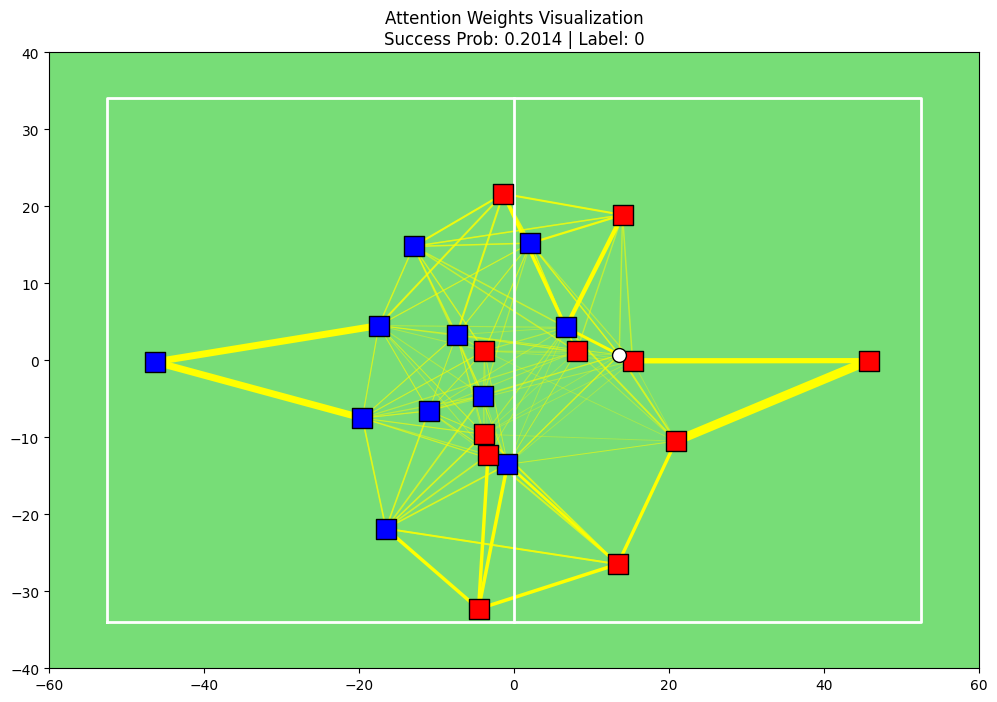

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import numpy as np

def visualize_attention(model, data, sample_idx=0):
    """
    特定のシーンにおけるアテンション係数と物理ゲートの影響を可視化する
    """
    model.eval()
    device = next(model.parameters()).device
    data = data.to(device)

    with torch.no_grad():
        # 推論実行（この時、内部で self.conv1.last_alpha に係数が保存される）
        out = model(data)
        probs = torch.exp(out) # log_softmaxを確率に戻す

        # 最終層または第1層のアテンション係数を取得 [num_edges, 1]
        alpha = model.conv1.last_alpha
        edge_index = data.edge_index

    # 座標データの取得
    pos = data.pos.cpu().numpy()
    x = pos[:, 0] * 52.5  # 正規化をメートルに戻す
    y = pos[:, 1] * 34.0
    node_features = data.x.cpu().numpy()

    # ピッチの描画
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_facecolor('#77dd77') # 緑色のピッチ

    # サッカーピッチの枠組み
    plt.plot([-52.5, 52.5, 52.5, -52.5, -52.5], [-34, -34, 34, 34, -34], color="white", lw=2)
    plt.plot([0, 0], [-34, 34], color="white", lw=2) # センターライン

    # エッジ（アテンション）の描画
    # すべて描画すると見づらいため、上位20%または閾値以上を描画
    max_alpha = alpha.max().item()
    for k in range(edge_index.shape[1]):
        src, dst = edge_index[0, k], edge_index[1, k]
        weight = alpha[k].item()

        # アテンションの強さを線の太さと透明度で表現
        if weight > max_alpha * 0.1: # 上位の係数のみ表示
            plt.plot([x[src], x[dst]], [y[src], y[dst]],
                     color='yellow', alpha=min(1.0, weight*5),
                     lw=weight*10, zorder=1)

    # ノード（選手・ボール）の描画
    for i in range(len(x)):
        team_val = node_features[i, 6]
        if team_val == 2.0: # ボール
            color, marker, size = 'white', 'o', 100
        elif team_val == 0.0: # Home
            color, marker, size = 'blue', 's', 200
        else: # Away
            color, marker, size = 'red', 's', 200

        ax.scatter(x[i], y[i], c=color, marker=marker, s=size, edgecolors='black', zorder=2)

    plt.title(f"Attention Weights Visualization\nSuccess Prob: {probs[0,1]:.4f} | Label: {data.y.item()}")
    plt.xlim(-60, 60)
    plt.ylim(-40, 40)
    plt.show()

# --- 実行例 ---
# テストデータの最初のシーンを表示
test_data_sample = all_data_list[0] # または任意のインデックス
visualize_attention(cv_model, test_data_sample)

✅ 可視化用モデルのロードに成功しました。

📊 PIGNN Analysis: True Positive (Success) - TOP ATTENTION DETAILS
Source   | Dest     | Weight     | Team Relation
--------------------------------------------------
Node  5 -> Node  3 | 1.0000     | Teammate
Node  8 -> Node  4 | 0.2910     | Teammate
Node  8 -> Node  5 | 0.2307     | Teammate
Node 11 -> Node  8 | 0.2998     | Opponent
Node 11 -> Node 19 | 0.2078     | Teammate
Node 11 -> Node 20 | 0.3952     | Teammate
Node 19 -> Node 11 | 0.3263     | Teammate
Node 19 -> Node 20 | 0.2138     | Teammate
Node 20 -> Node  4 | 0.4549     | Opponent
Node 20 -> Node 11 | 0.2681     | Teammate
Node 20 -> Node 15 | 0.8661     | Teammate
Node 21 -> Node  5 | 0.3150     | Opponent
Node 21 -> Node 11 | 0.2341     | Teammate


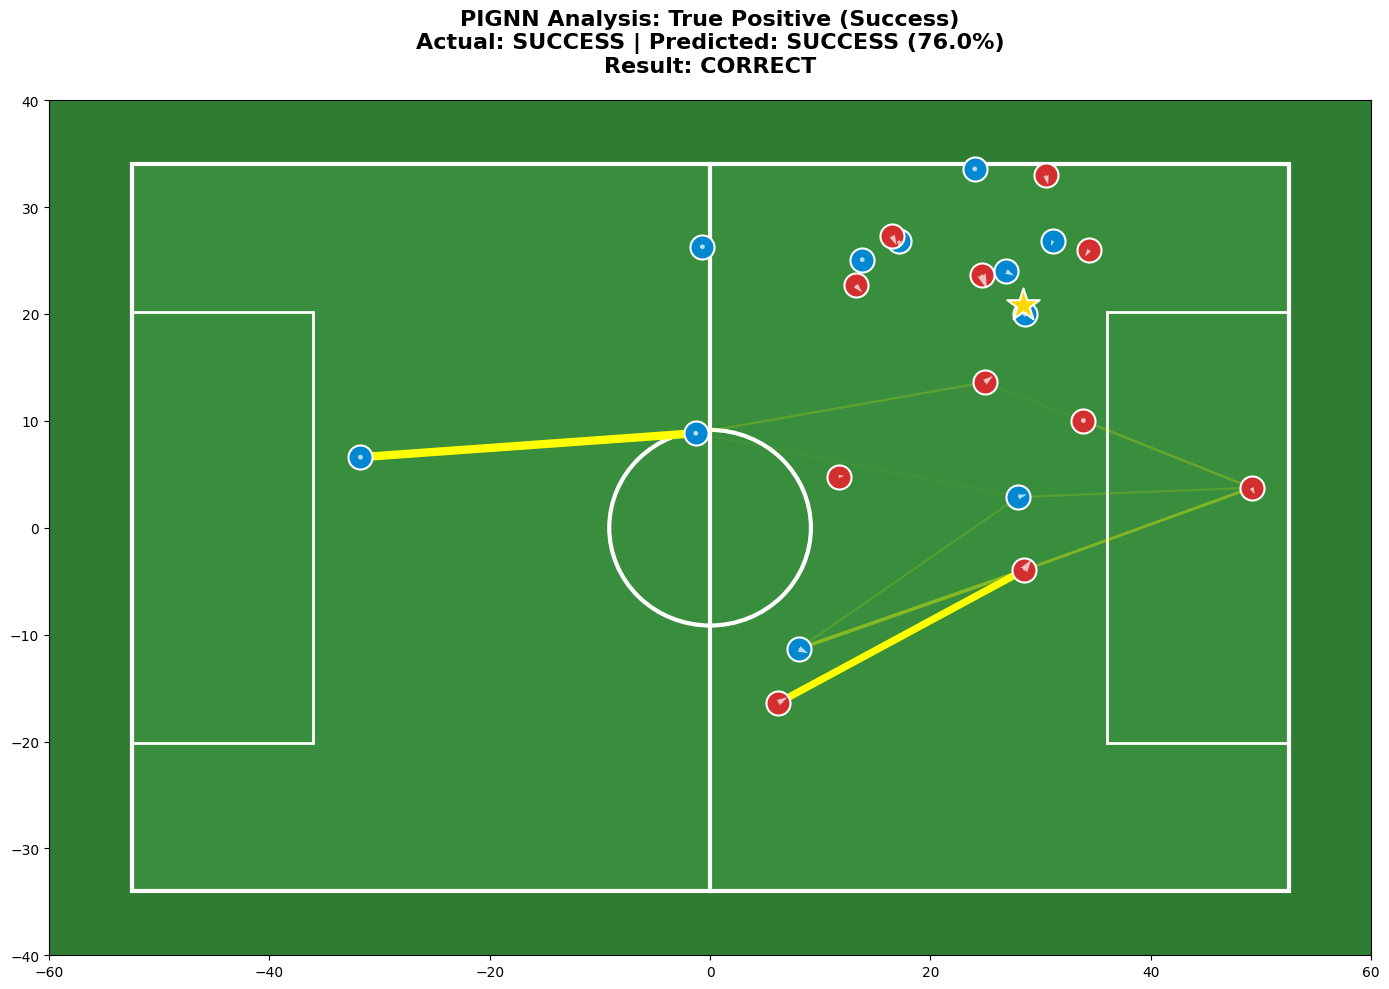


📊 PIGNN Analysis: True Negative (Failure) - TOP ATTENTION DETAILS
Source   | Dest     | Weight     | Team Relation
--------------------------------------------------
Node  5 -> Node  3 | 0.5001     | Teammate
Node  9 -> Node  3 | 0.4999     | Teammate
Node 11 -> Node 17 | 0.4560     | Teammate
Node 11 -> Node 19 | 0.5060     | Teammate
Node 12 -> Node 15 | 0.2284     | Teammate
Node 17 -> Node 11 | 0.4993     | Teammate
Node 17 -> Node 18 | 0.2456     | Teammate
Node 18 -> Node  1 | 0.2520     | Opponent
Node 18 -> Node 16 | 0.4489     | Teammate
Node 19 -> Node 11 | 0.5007     | Teammate
Node 19 -> Node 20 | 0.4555     | Teammate
Node 20 -> Node 15 | 0.4649     | Teammate
Node 22 -> Node 18 | 0.2882     | Ball -> Player


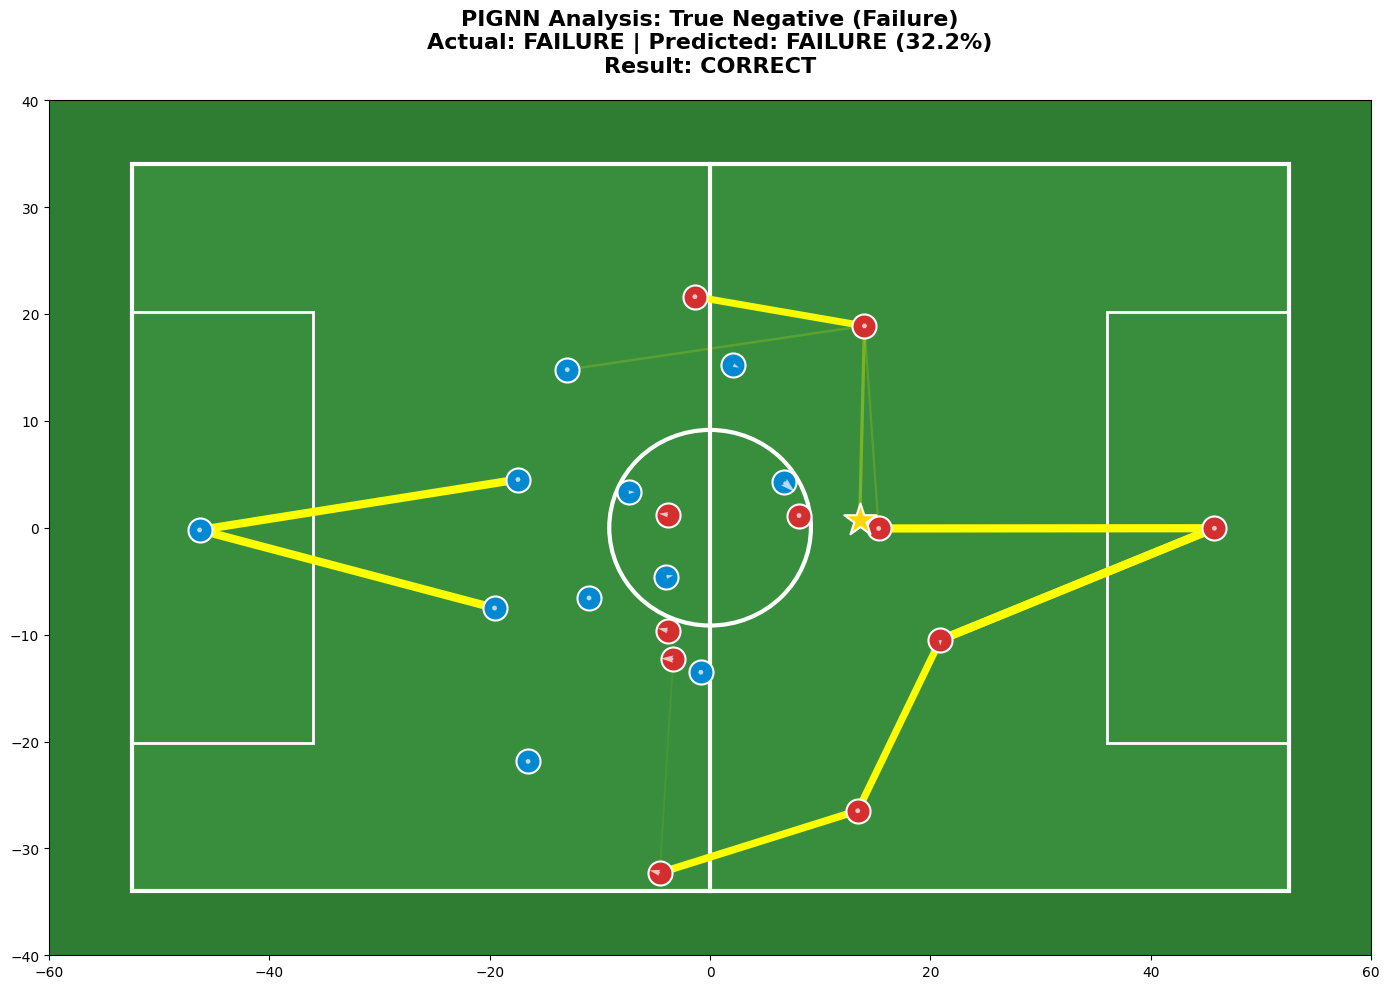

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
import os

# ==========================================
# 1. 可視化 & 数値抽出メイン関数
# ==========================================
def visualize_pignn_tactical_analysis(model, data_item, device, title="PIGNN Tactical Analysis"):
    model.eval()
    data_item = data_item.to(device)

    # --- 推論とアテンション・ゲート情報の抽出 ---
    # モデルのforwardを修正して attentionを返せるようにしている前提
    with torch.no_grad():
        out = model(data_item)
        # 最後に計算されたアテンション係数を取得 (PIGNNLayerで保持しているもの)
        # 2層構造の場合は conv1 または conv2 の alpha を取得
        att_weights = model.conv1.last_alpha
        edge_index = data_item.edge_index

        prob = torch.exp(out)[0, 1].item() # log_softmax なので exp を取る
        pred = out.argmax(dim=1).item()
        label = data_item.y.item()

    # --- 座標と速度の復元 ---
    pos = data_item.pos.cpu().numpy()
    # 速度はノード特徴量の index 2, 3 に入っている (px, py, vx, vy, ...)
    vel = data_item.x[:, 2:4].cpu().numpy()

    pos_plot = np.zeros_like(pos)
    pos_plot[:, 0] = pos[:, 0] * 52.5  # メートル換算
    pos_plot[:, 1] = pos[:, 1] * 34.0

    fig, ax = plt.subplots(figsize=(14, 10))

    # --- サッカー場の描画 ---
    ax.set_facecolor('#2e7d32')
    ax.add_patch(patches.Rectangle((-52.5, -34), 105, 68, fill=True, color='#388e3c', zorder=0))
    ax.add_patch(patches.Rectangle((-52.5, -34), 105, 68, fill=False, color='white', lw=3, zorder=1))
    ax.plot([0, 0], [-34, 34], color='white', lw=3, zorder=1)
    ax.add_patch(patches.Circle((0, 0), 9.15, edgecolor="white", facecolor="none", lw=3, zorder=1))
    ax.add_patch(patches.Rectangle((-52.5, -20.15), 16.5, 40.3, fill=False, color='white', lw=2, zorder=1))
    ax.add_patch(patches.Rectangle((52.5-16.5, -20.15), 16.5, 40.3, fill=False, color='white', lw=2, zorder=1))

    # --- アテンション係数の描画 & 数値出力 ---
    att_weights = att_weights.cpu().numpy().flatten()
    edge_index = edge_index.cpu().numpy()
    team_ids = data_item.x[:, 6].cpu().numpy() # 0:Home, 1:Away, 2:Ball

    if len(att_weights) > 0:
        # 上位5%を表示（DFLデータはエッジ数が多いため）
        threshold = np.percentile(att_weights, 95)
        max_att = att_weights.max()

        print(f"\n{'='*50}")
        print(f"📊 {title} - TOP ATTENTION DETAILS")
        print(f"{'='*50}")
        print(f"{'Source':<8} | {'Dest':<8} | {'Weight':<10} | {'Team Relation'}")
        print(f"{'-'*50}")

        for i in range(edge_index.shape[1]):
            if att_weights[i] > threshold:
                src, dst = edge_index[0, i], edge_index[1, i]
                weight = att_weights[i]

                # チーム関係の言語化
                rel = "Teammate" if team_ids[src] == team_ids[dst] else "Opponent"
                if team_ids[src] == 2.0: rel = "Ball -> Player"

                print(f"Node {src:2d} -> Node {dst:2d} | {weight:.4f}     | {rel}")

                # 描画（黄色い線）
                alpha_val = (weight - threshold) / (max_att - threshold + 1e-9)
                ax.plot([pos_plot[src, 0], pos_plot[dst, 0]],
                        [pos_plot[src, 1], pos_plot[dst, 1]],
                        color='#FFFF00', alpha=min(1.0, alpha_val * 1.2),
                        lw=1.0 + alpha_val*5, zorder=2)

    # --- 選手と速度ベクトルの描画 ---
    vel_scale = 10.0
    for i in range(len(pos_plot)):
        if team_ids[i] == 2.0: # ボール
            color, marker, size, z = 'gold', '*', 600, 15
        elif team_ids[i] == 0.0: # ホーム（攻撃側と想定）
            color, marker, size, z = '#0288d1', 'o', 300, 10
        else: # アウェイ（守備側と想定）
            color, marker, size, z = '#d32f2f', 'o', 300, 10

        # 速度ベクトル
        if team_ids[i] != 2.0:
            ax.quiver(pos_plot[i, 0], pos_plot[i, 1],
                      vel[i, 0], vel[i, 1],
                      color='white', alpha=0.7, angles='xy', scale_units='xy',
                      scale=1/vel_scale, width=0.004, zorder=20)

        # 選手ノード
        ax.scatter(pos_plot[i, 0], pos_plot[i, 1], c=color, marker=marker, s=size,
                   edgecolors='white', linewidth=1.5, zorder=15)

    # --- テキスト設定 ---
    res_text = "SUCCESS" if pred == 1 else "FAILURE"
    match_status = "CORRECT" if label == pred else "INCORRECT"
    ax.set_title(f"{title}\nActual: {'SUCCESS' if label==1 else 'FAILURE'} | Predicted: {res_text} ({prob:.1%})\nResult: {match_status}",
                 fontsize=16, fontweight='bold', pad=20)

    ax.set_xlim(-60, 60); ax.set_ylim(-40, 40)
    plt.tight_layout()
    plt.show()

# ==========================================
# 2. 自動抽出・比較実行関数
# ==========================================
def run_tactical_comparison(model, data_list, device):
    success_case, failure_case = None, None
    model.eval()

    # 正解したサンプルの中から、成功シーンと失敗シーンを1つずつ探す
    for data in data_list:
        with torch.no_grad():
            d_gpu = data.to(device)
            out = model(d_gpu)
            pred = out.argmax(dim=1).item()
            label = d_gpu.y.item()

            if pred == label:
                if label == 1 and success_case is None: success_case = data
                elif label == 0 and failure_case is None: failure_case = data
        if success_case is not None and failure_case is not None: break

    if success_case:
        visualize_pignn_tactical_analysis(model, success_case, device, title="PIGNN Analysis: True Positive (Success)")
    if failure_case:
        visualize_pignn_tactical_analysis(model, failure_case, device, title="PIGNN Analysis: True Negative (Failure)")

# ==========================================
# 3. 実行
# ==========================================
# 注意: すでに PIGNNClassifier は定義済みである必要があります。
# 今回の物理ゲート版 (in_channels=7) を使用します。
model_viz = PIGNNClassifier(in_channels=7, hidden_channels=64).to(device)

# CVで保存したベストモデルをロード
best_path = "/content/drive/MyDrive/GNN_Football_Analysis/Models/PIGNN_v17_Gate/best_overall_pignn.pth"
if os.path.exists(best_path):
    model_viz.load_state_dict(torch.load(best_path, map_location=device))
    print("✅ 可視化用モデルのロードに成功しました。")
    run_tactical_comparison(model_viz, all_data_list, device)
else:
    print(f"⚠️ モデルが見つかりません。パスを確認してください: {best_path}")

In [ ]:
import torch
import numpy as np
import pandas as pd
from collections import defaultdict

def analyze_node_attention_bias(model, data_list, device, top_n=5):
    model.eval()
    node_att_score = defaultdict(float)
    node_count = defaultdict(int)

    print("🔍 全データのノード別アテンション集計を開始...")

    with torch.no_grad():
        for data in data_list:
            data = data.to(device)
            _ = model(data)
            # 最後に計算されたアテンション(Layer1)を取得
            att = model.conv1.last_alpha.cpu().numpy().flatten()
            edge_index = data.edge_index.cpu().numpy()

            for i in range(len(att)):
                dst = edge_index[1, i] # 受け取り側ノード
                node_att_score[dst] += att[i]
                node_count[dst] += 1

    # 平均アテンション獲得スコアを計算
    rank = []
    for node_idx in node_att_score:
        avg_score = node_att_score[node_idx] / node_count[node_idx]
        rank.append((node_idx, avg_score))

    rank = sorted(rank, key=lambda x: x[1], reverse=True)

    print(f"\n🏆 ノード別 平均アテンション獲得ランキング (TOP {top_n})")
    print("-" * 45)
    for i, (idx, score) in enumerate(rank[:top_n]):
        role = "GK? (Static Bias)" if i == 0 else "Active Player"
        print(f"Rank {i+1}: Node {idx:2d} | Avg Attention: {score:.4f} | {role}")

    return [r[0] for r in rank[:2]] # 上位2名をGK候補として返す

def get_fp_only_stats(model, data_list, device, gk_indices):
    model.eval()
    all_fp_att = []

    with torch.no_grad():
        for data in data_list:
            data = data.to(device)
            _ = model(data)
            att = model.conv1.last_alpha.cpu().numpy().flatten()
            edge_index = data.edge_index.cpu().numpy()

            # GKを除外したエッジの係数のみを抽出
            mask = ~np.isin(edge_index[0], gk_indices) & ~np.isin(edge_index[1], gk_indices)
            fp_att = att[mask]
            all_fp_att.extend(fp_att.tolist())

    print(f"\n📊 FP(フィールドプレーヤー)間アテンション統計 (GK: {gk_indices} 除外)")
    print("-" * 45)
    print(f"FPエッジ総数: {len(all_fp_att)}")
    print(f"平均アテンション: {np.mean(all_fp_att):.4f}")
    print(f"最大アテンション: {np.max(all_fp_att):.4f}")
    print(f"標準偏差:       {np.std(all_fp_att):.4f}")

# ==========================================
# 実行セクション
# ==========================================
# 1. アテンションを集めすぎているノード（GK候補）を特定
gk_candidates = analyze_node_attention_bias(model_viz, all_data_list, device)

# 2. 特定されたGK候補を除外して、FPのみの純粋な統計を出す
get_fp_only_stats(model_viz, all_data_list, device, gk_candidates)

🔍 全データのノード別アテンション集計を開始...

🏆 ノード別 平均アテンション獲得ランキング (TOP 5)
---------------------------------------------
Rank 1: Node 11 | Avg Attention: 0.1126 | GK? (Static Bias)
Rank 2: Node 16 | Avg Attention: 0.1092 | Active Player
Rank 3: Node 23 | Avg Attention: 0.1075 | Active Player
Rank 4: Node 22 | Avg Attention: 0.0927 | Active Player
Rank 5: Node  5 | Avg Attention: 0.0902 | Active Player

📊 FP(フィールドプレーヤー)間アテンション統計 (GK: [np.int64(11), np.int64(16)] 除外)
---------------------------------------------
FPエッジ総数: 765500
平均アテンション: 0.0813
最大アテンション: 1.0000
標準偏差:       0.0675


✅ 可視化用モデルのロードに成功しました。

--- GKノード特定フェーズ ---
 identified GK candidates based on avg attention: [np.int64(11), np.int64(16)]
 identified GK node indices: [np.int64(11), np.int64(16)]
--------------------------

📊 PIGNN Analysis: True Positive (FP-only) - TOP ATTENTION DETAILS (Excluding GK)
Source   | Dest     | Weight     | Team Relation
--------------------------------------------------
Node  0 -> Node  9 | 0.1620     | Teammate
Node  5 -> Node  3 | 1.0000     | Teammate
Node  8 -> Node  4 | 0.2910     | Teammate
Node  8 -> Node  5 | 0.2307     | Teammate
Node 19 -> Node  8 | 0.1622     | Opponent
Node 19 -> Node 13 | 0.1957     | Teammate
Node 19 -> Node 20 | 0.2138     | Teammate
Node 20 -> Node  4 | 0.4549     | Opponent
Node 20 -> Node 13 | 0.1607     | Teammate
Node 20 -> Node 15 | 0.8661     | Teammate
Node 21 -> Node  5 | 0.3150     | Opponent

📊 FP-only Attention Statistics
  Count: 216
  Mean: 0.0888
  Max: 1.0000
  Std Dev: 0.0970


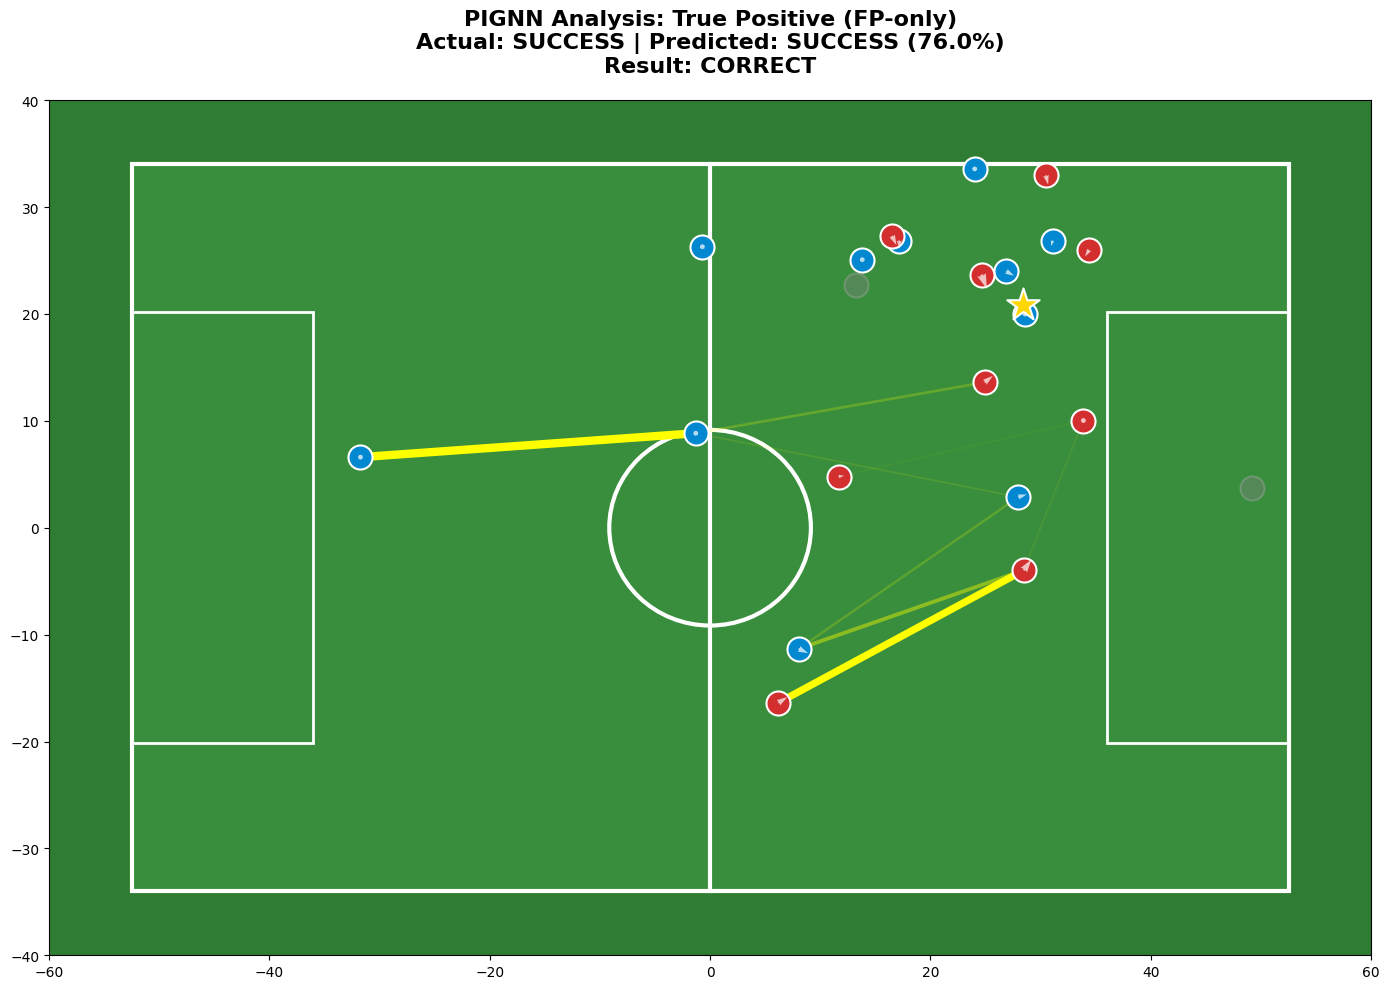


📊 PIGNN Analysis: True Negative (FP-only) - TOP ATTENTION DETAILS (Excluding GK)
Source   | Dest     | Weight     | Team Relation
--------------------------------------------------
Node  5 -> Node  3 | 0.5001     | Teammate
Node  8 -> Node 15 | 0.1826     | Opponent
Node  9 -> Node  3 | 0.4999     | Teammate
Node 12 -> Node 15 | 0.2284     | Teammate
Node 17 -> Node 18 | 0.2456     | Teammate
Node 18 -> Node  1 | 0.2520     | Opponent
Node 19 -> Node 20 | 0.4555     | Teammate
Node 20 -> Node  4 | 0.1943     | Opponent
Node 20 -> Node 15 | 0.4649     | Teammate
Node 22 -> Node  6 | 0.1967     | Ball -> Player
Node 22 -> Node 10 | 0.1928     | Ball -> Player
Node 22 -> Node 18 | 0.2882     | Ball -> Player

📊 FP-only Attention Statistics
  Count: 238
  Mean: 0.0821
  Max: 0.5001
  Std Dev: 0.0726


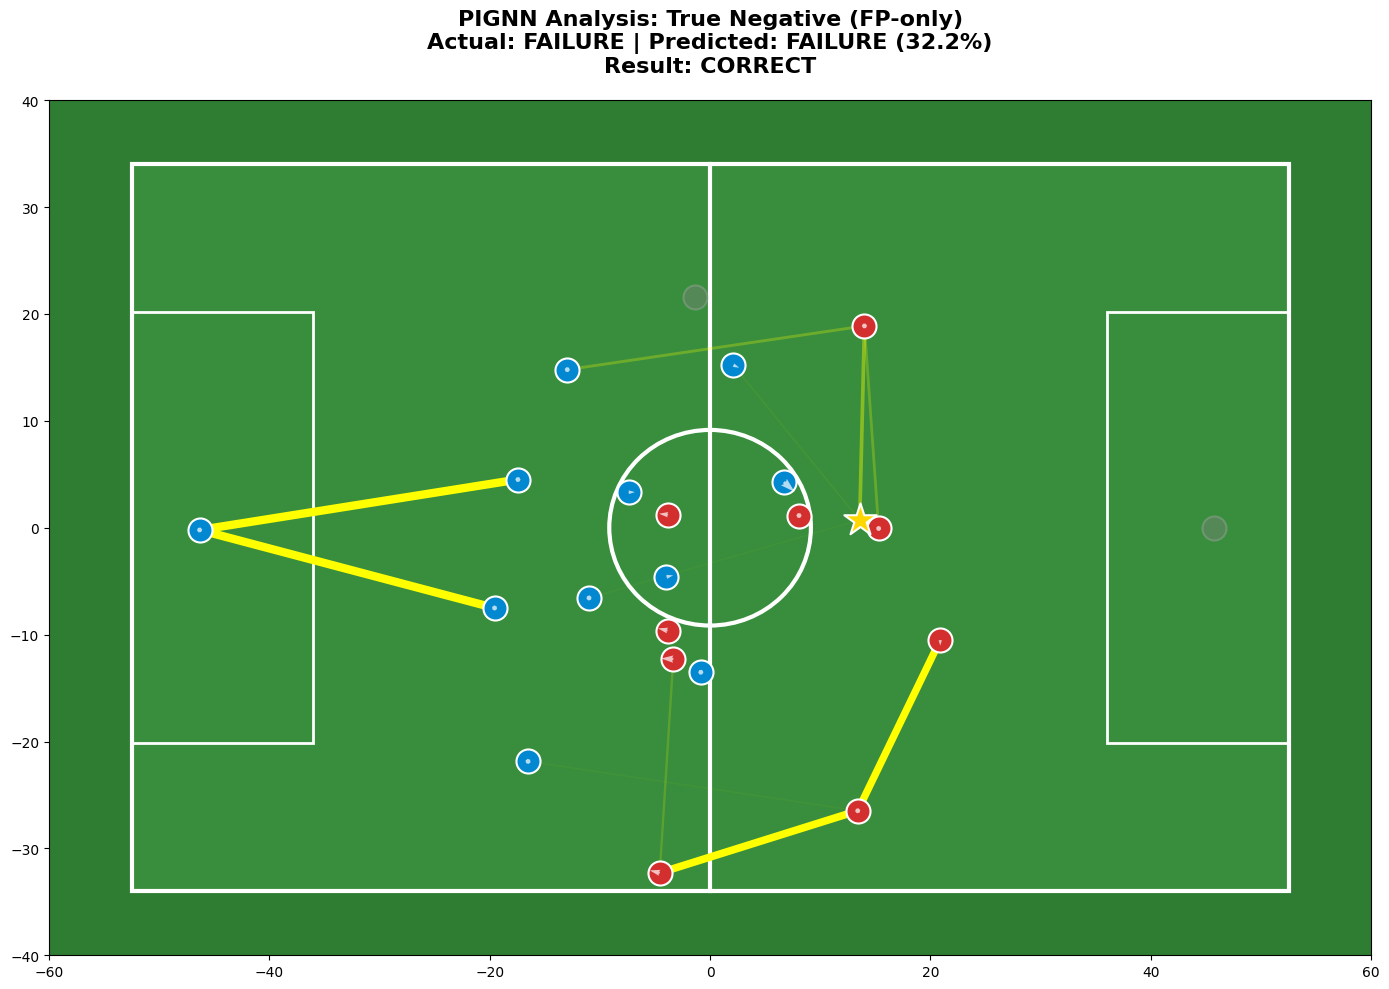

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
import os
from collections import defaultdict

# ==========================================
# 0. ヘルパー関数 (GK特定)
# ==========================================
def identify_gk_nodes(model, data_list, device, top_n_candidates=2):
    """
    全データを通じてアテンション獲得量が多いノードを特定し、GK候補として返却
    """
    model.eval()
    node_att_score_sum = defaultdict(float)
    node_att_count = defaultdict(int)

    with torch.no_grad():
        for data in data_list:
            data_gpu = data.to(device)
            _ = model(data_gpu)
            att = model.conv1.last_alpha.cpu().numpy().flatten()
            edge_index = data_gpu.edge_index.cpu().numpy()

            for i in range(len(att)):
                dst = edge_index[1, i] # 受け取り側ノード
                node_att_score_sum[dst] += att[i]
                node_att_count[dst] += 1

    # 平均アテンションスコアでランキング
    avg_att_rank = []
    for node_idx in node_att_score_sum:
        if node_att_count[node_idx] > 0:
            avg_att_rank.append((node_idx, node_att_score_sum[node_idx] / node_att_count[node_idx]))

    avg_att_rank = sorted(avg_att_rank, key=lambda x: x[1], reverse=True)

    # 上位N名をGK候補として返す (通常0番と11番が多い)
    gk_candidates = [r[0] for r in avg_att_rank[:top_n_candidates]]
    print(f" identified GK candidates based on avg attention: {gk_candidates}")
    return gk_candidates

# ==========================================
# 1. 可視化 & 数値抽出メイン関数 (GK考慮版)
# ==========================================
def visualize_pignn_tactical_analysis_gk_filtered(model, data_item, device, gk_indices, title="PIGNN Tactical Analysis (FP-only)"):
    model.eval()
    data_item = data_item.to(device)

    # --- 推論とアテンション・ゲート情報の抽出 ---
    with torch.no_grad():
        out = model(data_item)
        att_weights = model.conv1.last_alpha
        edge_index = data_item.edge_index

        prob = torch.exp(out)[0, 1].item()
        pred = out.argmax(dim=1).item()
        label = data_item.y.item()

    # --- 座標と速度の復元 ---
    pos = data_item.pos.cpu().numpy()
    vel = data_item.x[:, 2:4].cpu().numpy() # xの特徴量からvx, vyを取得

    pos_plot = np.zeros_like(pos)
    pos_plot[:, 0] = pos[:, 0] * 52.5  # メートル換算
    pos_plot[:, 1] = pos[:, 1] * 34.0

    fig, ax = plt.subplots(figsize=(14, 10))

    # --- サッカー場の描画 ---
    ax.set_facecolor('#2e7d32')
    ax.add_patch(patches.Rectangle((-52.5, -34), 105, 68, fill=True, color='#388e3c', zorder=0))
    ax.add_patch(patches.Rectangle((-52.5, -34), 105, 68, fill=False, color='white', lw=3, zorder=1))
    ax.plot([0, 0], [-34, 34], color='white', lw=3, zorder=1)
    ax.add_patch(patches.Circle((0, 0), 9.15, edgecolor="white", facecolor="none", lw=3, zorder=1))
    ax.add_patch(patches.Rectangle((-52.5, -20.15), 16.5, 40.3, fill=False, color='white', lw=2, zorder=1))
    ax.add_patch(patches.Rectangle((52.5-16.5, -20.15), 16.5, 40.3, fill=False, color='white', lw=2, zorder=1))

    # --- アテンション係数の描画 & 数値出力 (GK関連エッジは非表示) ---
    att_weights = att_weights.cpu().numpy().flatten()
    edge_index = edge_index.cpu().numpy()
    team_ids = data_item.x[:, 6].cpu().numpy() # 0:Home, 1:Away, 2:Ball

    fp_att_values = [] # GKを除外したアテンション値のリスト

    if len(att_weights) > 0:
        # 上位5%を表示
        # GKを除外したアテンションで閾値を計算するため、一時的にFPのみのリストを作成
        temp_fp_att = []
        for i in range(edge_index.shape[1]):
            src, dst = edge_index[0, i], edge_index[1, i]
            if src not in gk_indices and dst not in gk_indices:
                temp_fp_att.append(att_weights[i])

        threshold = np.percentile(temp_fp_att, 95) if temp_fp_att else 0.0
        max_att = np.max(temp_fp_att) if temp_fp_att else 1.0


        print(f"\n{'='*50}")
        print(f"📊 {title} - TOP ATTENTION DETAILS (Excluding GK)")
        print(f"{'='*50}")
        print(f"{'Source':<8} | {'Dest':<8} | {'Weight':<10} | {'Team Relation'}")
        print(f"{'-'*50}")

        for i in range(edge_index.shape[1]):
            src, dst = edge_index[0, i], edge_index[1, i]
            weight = att_weights[i]

            # GK関連のエッジは描画・統計から除外
            if src in gk_indices or dst in gk_indices:
                continue

            fp_att_values.append(weight) # FPアテンションリストに追加

            if weight > threshold: # 上位のアテンションのみ表示
                # チーム関係の言語化
                rel = "Teammate" if team_ids[src] == team_ids[dst] else "Opponent"
                if team_ids[src] == 2.0: rel = "Ball -> Player"

                print(f"Node {src:2d} -> Node {dst:2d} | {weight:.4f}     | {rel}")

                # 描画（黄色い線）
                alpha_val = (weight - threshold) / (max_att - threshold + 1e-9)
                ax.plot([pos_plot[src, 0], pos_plot[dst, 0]],
                        [pos_plot[src, 1], pos_plot[dst, 1]],
                        color='#FFFF00', alpha=min(1.0, alpha_val * 1.2),
                        lw=1.0 + alpha_val*5, zorder=2)

    # FPのみのアテンション統計出力
    if fp_att_values:
        print(f"\n📊 FP-only Attention Statistics")
        print(f"  Count: {len(fp_att_values)}")
        print(f"  Mean: {np.mean(fp_att_values):.4f}")
        print(f"  Max: {np.max(fp_att_values):.4f}")
        print(f"  Std Dev: {np.std(fp_att_values):.4f}")
    else:
        print("\nNo FP-only attention edges found for statistics.")

    # --- 選手と速度ベクトルの描画 ---
    vel_scale = 10.0
    for i in range(len(pos_plot)):
        if i in gk_indices: # 特定されたGKはグレーアウト
            color, marker, size, z = 'gray', 'o', 300, 10
            edge_color = 'darkgray'
            alpha_node = 0.4
        elif team_ids[i] == 2.0: # ボール
            color, marker, size, z = 'gold', '*', 600, 15
            edge_color = 'white'
            alpha_node = 1.0
        elif team_ids[i] == 0.0: # ホーム（攻撃側と想定）
            color, marker, size, z = '#0288d1', 'o', 300, 10
            edge_color = 'white'
            alpha_node = 1.0
        else: # アウェイ（守備側と想定）
            color, marker, size, z = '#d32f2f', 'o', 300, 10
            edge_color = 'white'
            alpha_node = 1.0

        # 速度ベクトル (GK以外のFPのみ描画)
        if i not in gk_indices and team_ids[i] != 2.0:
            ax.quiver(pos_plot[i, 0], pos_plot[i, 1],
                      vel[i, 0], vel[i, 1],
                      color='white', alpha=alpha_node * 0.7, angles='xy', scale_units='xy',
                      scale=1/vel_scale, width=0.004, zorder=20)

        # 選手ノード
        ax.scatter(pos_plot[i, 0], pos_plot[i, 1], c=color, marker=marker, s=size,
                   edgecolors=edge_color, linewidth=1.5, zorder=15, alpha=alpha_node)

    # --- タイトルと表示設定 ---
    res_text = "SUCCESS" if pred == 1 else "FAILURE"
    match_status = "CORRECT" if label == pred else "INCORRECT"
    ax.set_title(f"{title}\nActual: {'SUCCESS' if label==1 else 'FAILURE'} | Predicted: {res_text} ({prob:.1%})\nResult: {match_status}",
                 fontsize=16, fontweight='bold', pad=20)

    ax.set_xlim(-60, 60); ax.set_ylim(-40, 40)
    plt.tight_layout()
    plt.show()

# ==========================================
# 2. 自動抽出・比較実行関数 (GK考慮版)
# ==========================================
def run_tactical_comparison_gk_filtered(model, data_list, device, gk_indices):
    success_case, failure_case = None, None
    model.eval()

    # 正解したサンプルの中から、成功シーンと失敗シーンを1つずつ探す
    for data in data_list:
        with torch.no_grad():
            d_gpu = data.to(device)
            out = model(d_gpu)
            pred = out.argmax(dim=1).item()
            label = d_gpu.y.item()

            if pred == label:
                if label == 1 and success_case is None: success_case = data
                elif label == 0 and failure_case is None: failure_case = data
        if success_case is not None and failure_case is not None: break

    if success_case:
        visualize_pignn_tactical_analysis_gk_filtered(model, success_case, device, gk_indices, title="PIGNN Analysis: True Positive (FP-only)")
    if failure_case:
        visualize_pignn_tactical_analysis_gk_filtered(model, failure_case, device, gk_indices, title="PIGNN Analysis: True Negative (FP-only)")

# ==========================================
# 3. 実行セクション
# ==========================================
# PIGNNモデルの準備（CVで使ったモデルと同じ）
model_viz = PIGNNClassifier(in_channels=7, hidden_channels=64).to(device)

# CVで保存したベストモデルをロード
best_path = "/content/drive/MyDrive/GNN_Football_Analysis/Models/PIGNN_v17_Gate/best_overall_pignn.pth"
if os.path.exists(best_path):
    model_viz.load_state_dict(torch.load(best_path, map_location=device))
    print("✅ 可視化用モデルのロードに成功しました。")

    # 1. GK候補の特定
    print("\n--- GKノード特定フェーズ ---")
    gk_nodes = identify_gk_nodes(model_viz, all_data_list, device)
    print(f" identified GK node indices: {gk_nodes}")
    print("--------------------------")

    # 2. GKを除外して可視化とFP統計を実行
    run_tactical_comparison_gk_filtered(model_viz, all_data_list, device, gk_nodes)
else:
    print(f"⚠️ モデルが見つかりません。パスを確認してください: {best_path}")

📌 GK特定（x最小/最大）: Node 3 & Node 11


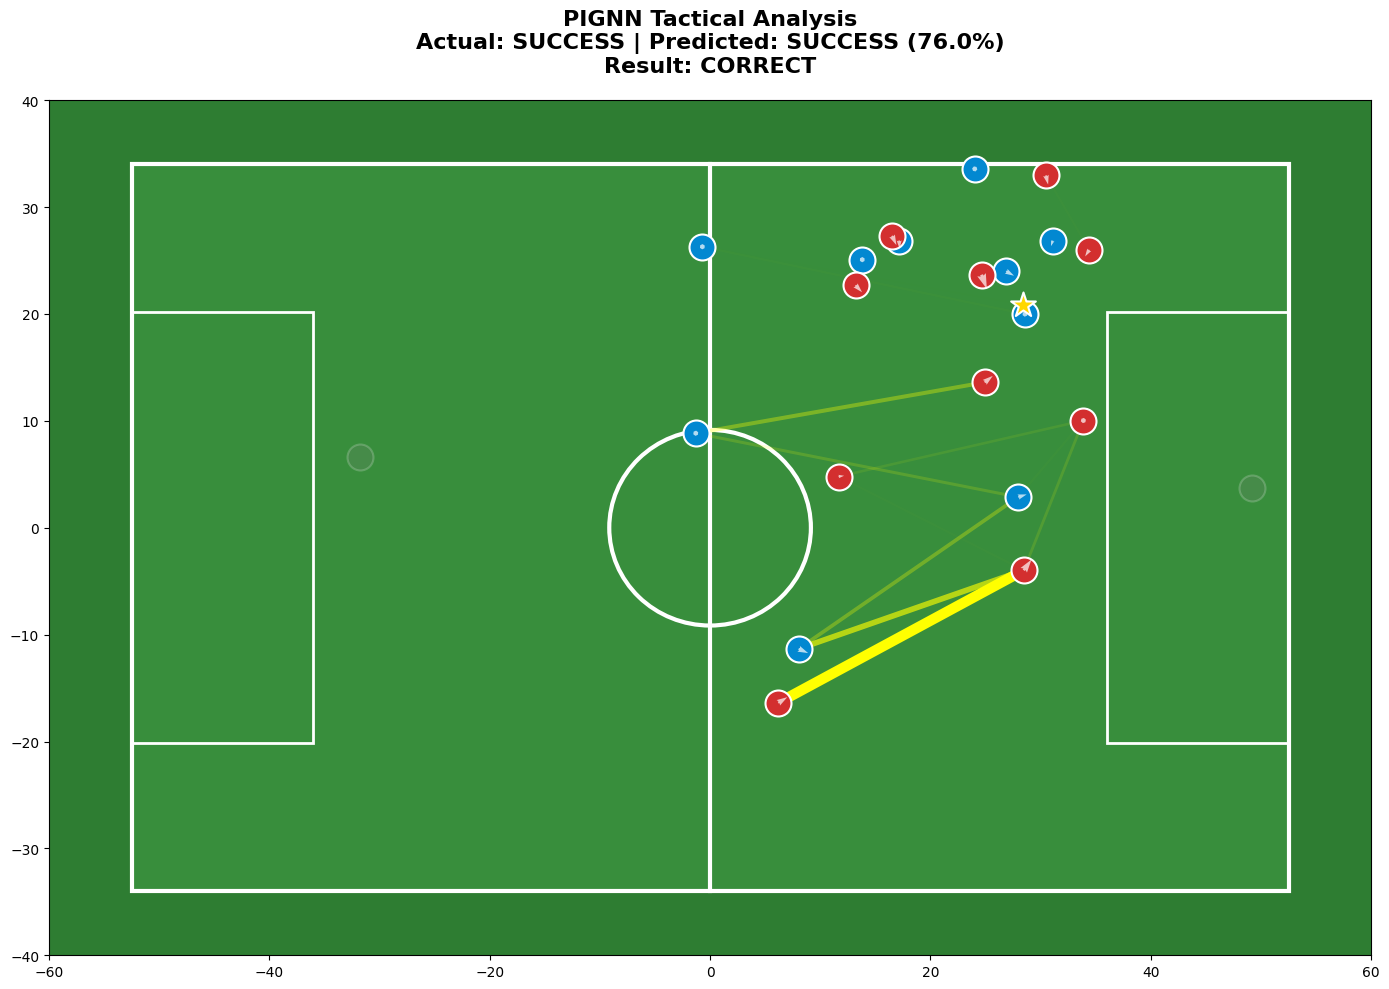

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch

def visualize_pignn_final_min_max_with_vel(model, data_item, device, title="PIGNN Tactical Analysis"):
    model.eval()
    data_item = data_item.to(device)

    # --- 1. 推論とデータ抽出 ---
    with torch.no_grad():
        out = model(data_item)
        att_weights = model.conv1.last_alpha.cpu().numpy().flatten()
        edge_index = data_item.edge_index.cpu().numpy()

        prob = torch.exp(out)[0, 1].item()
        pred = out.argmax(dim=1).item()
        label = data_item.y.item()

    # --- 2. 座標と速度の復元 ---
    pos = data_item.pos.cpu().numpy()
    # 速度はノード特徴量の index 2, 3 に入っている (px, py, vx, vy, ...)
    vel = data_item.x[:, 2:4].cpu().numpy()

    pos_plot = np.zeros_like(pos)
    pos_plot[:, 0] = pos[:, 0] * 52.5
    pos_plot[:, 1] = pos[:, 1] * 34.0

    team_ids = data_item.x[:, 6].cpu().numpy() # 0:Home, 1:Away, 2:Ball

    # --- 3. ロジック：x座標の最大・最小をGKとして特定 ---
    # 選手のみ（ボールを除外）のインデックスを取得
    player_indices = np.where(team_ids != 2.0)[0]
    # 選手の中で最も左(min)と右(max)を特定
    idx_min_x = player_indices[np.argmin(pos[player_indices, 0])]
    idx_max_x = player_indices[np.argmax(pos[player_indices, 0])]
    gk_indices = [idx_min_x, idx_max_x]

    print(f"📌 GK特定（x最小/最大）: Node {idx_min_x} & Node {idx_max_x}")

    # --- 4. 描画設定 ---
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.set_facecolor('#2e7d32')
    ax.add_patch(patches.Rectangle((-52.5, -34), 105, 68, fill=True, color='#388e3c', zorder=0))
    ax.add_patch(patches.Rectangle((-52.5, -34), 105, 68, fill=False, color='white', lw=3, zorder=1))
    ax.plot([0, 0], [-34, 34], color='white', lw=3, zorder=1)
    ax.add_patch(patches.Circle((0, 0), 9.15, edgecolor="white", facecolor="none", lw=3, zorder=1))
    ax.add_patch(patches.Rectangle((-52.5, -20.15), 16.5, 40.3, fill=False, color='white', lw=2, zorder=1))
    ax.add_patch(patches.Rectangle((52.5-16.5, -20.15), 16.5, 40.3, fill=False, color='white', lw=2, zorder=1))

    # --- 5. アテンション係数の描画 (GK除外) ---
    active_att_values = [att_weights[i] for i in range(len(att_weights))
                         if edge_index[0, i] not in gk_indices and edge_index[1, i] not in gk_indices]

    if active_att_values:
        threshold = np.percentile(active_att_values, 95)
        max_att = np.max(active_att_values)
        for i in range(len(att_weights)):
            src, dst = edge_index[0, i], edge_index[1, i]
            if src in gk_indices or dst in gk_indices: continue

            weight = att_weights[i]
            if weight >= threshold:
                alpha_val = (weight - threshold) / (max_att - threshold + 1e-9)
                ax.plot([pos_plot[src, 0], pos_plot[dst, 0]],
                        [pos_plot[src, 1], pos_plot[dst, 1]],
                        color='#FFFF00', alpha=min(1.0, alpha_val * 1.5),
                        lw=1.5 + alpha_val*6, zorder=2)

    # --- 6. 選手・速度ベクトルの描画 ---
    vel_scale = 10.0
    for i in range(len(pos_plot)):
        is_gk = i in gk_indices
        if is_gk:
            color, alpha, z = 'gray', 0.2, 5
        elif team_ids[i] == 2.0: # ボール
            color, alpha, z = 'gold', 1.0, 20
        elif team_ids[i] == 0.0: # Home
            color, alpha, z = '#0288d1', 1.0, 15
        else: # Away
            color, alpha, z = '#d32f2f', 1.0, 15

        # 速度ベクトル (GK以外のFPのみ描画)
        if not is_gk and team_ids[i] != 2.0:
            ax.quiver(pos_plot[i, 0], pos_plot[i, 1],
                      vel[i, 0], vel[i, 1],
                      color='white', alpha=0.7, angles='xy', scale_units='xy',
                      scale=1/vel_scale, width=0.004, zorder=20)

        # 選手ノード
        ax.scatter(pos_plot[i, 0], pos_plot[i, 1], c=color, alpha=alpha, s=350,
                   marker='o' if team_ids[i] != 2.0 else '*',
                   edgecolors='white', linewidth=1.5, zorder=z)

    # --- タイトル表示 ---
    res_text = "SUCCESS" if pred == 1 else "FAILURE"
    match_status = "CORRECT" if label == pred else "INCORRECT"
    ax.set_title(f"{title}\nActual: {'SUCCESS' if label==1 else 'FAILURE'} | Predicted: {res_text} ({prob:.1%})\nResult: {match_status}",
                 fontsize=16, fontweight='bold', pad=20)

    ax.set_xlim(-60, 60); ax.set_ylim(-40, 40)
    plt.tight_layout()
    plt.show()

# 実行
visualize_pignn_final_min_max_with_vel(model_viz, viz_success_case, device)

🎬 失敗シーン (True Negative) の描画を開始します...
📌 GK特定（x最小/最大）: Node 3 & Node 11


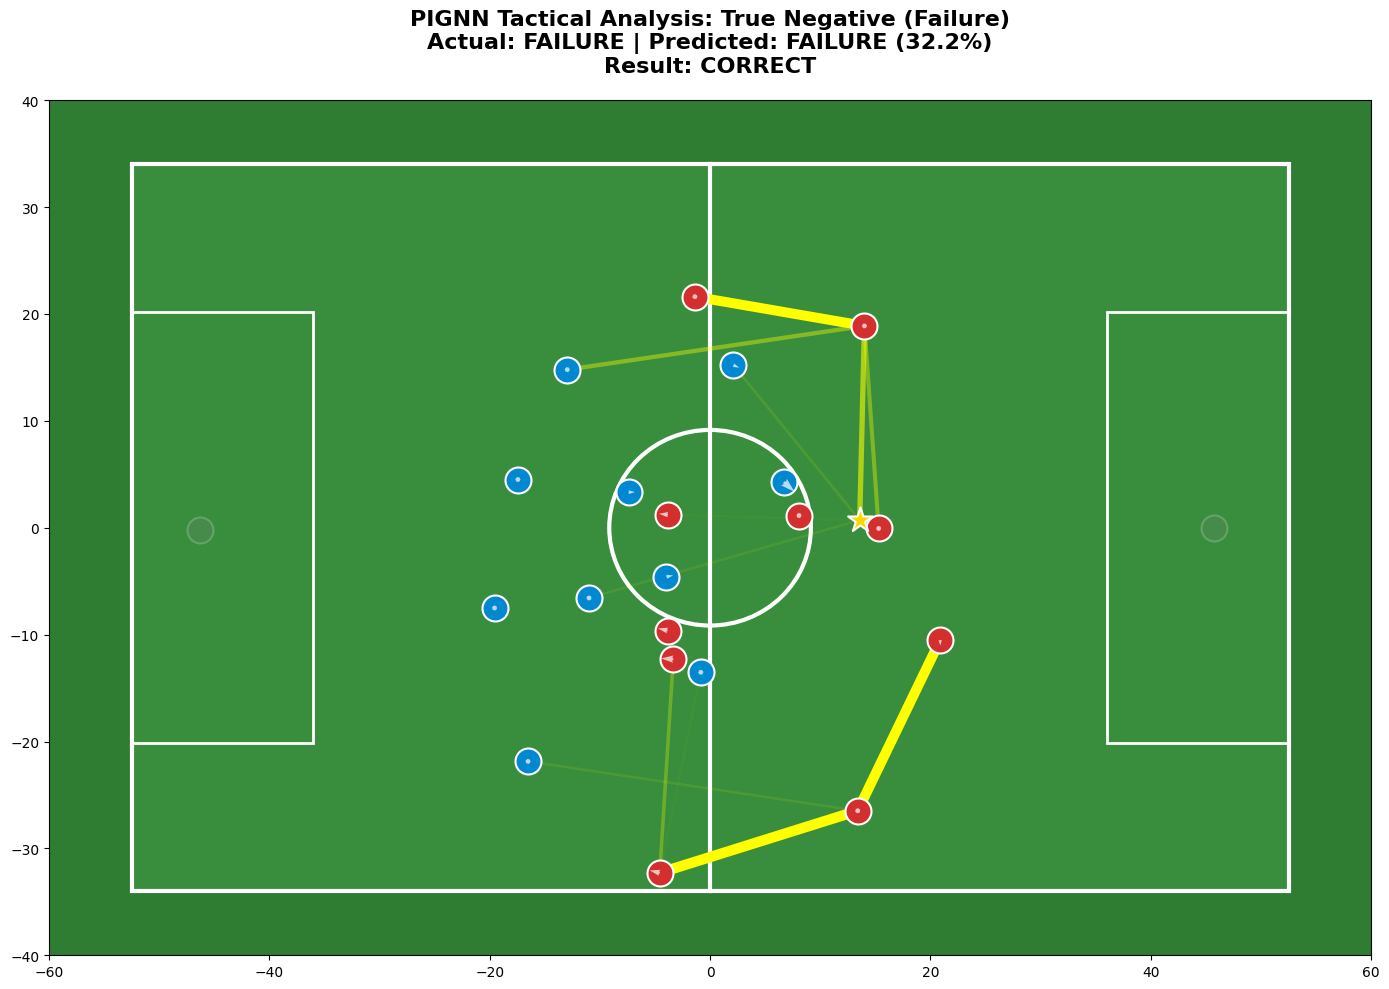

In [ ]:
# 失敗シーン（モデルが正しく「失敗」と予測したケース）の描画
if viz_failure_case is not None:
    print("🎬 失敗シーン (True Negative) の描画を開始します...")
    visualize_pignn_final_min_max_with_vel(
        model_viz,
        viz_failure_case,
        device,
        title="PIGNN Tactical Analysis: True Negative (Failure)"
    )
else:
    print("⚠️ 失敗シーンのサンプルが見つかりませんでした。抽出ループを確認してください。")

✅ Baseline Accuracy: 0.7953
🔥 x               | Importance: 0.0761
🔥 y               | Importance: 0.0025
🔥 vx              | Importance: 0.0129
🔥 vy              | Importance: 0.0009
🔥 dist_to_ball    | Importance: 0.0000
🔥 angle_to_goal   | Importance: 0.0000
🔥 team_id         | Importance: 0.0336


/tmp/ipython-input-854680169.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=df_pfi, palette='viridis')


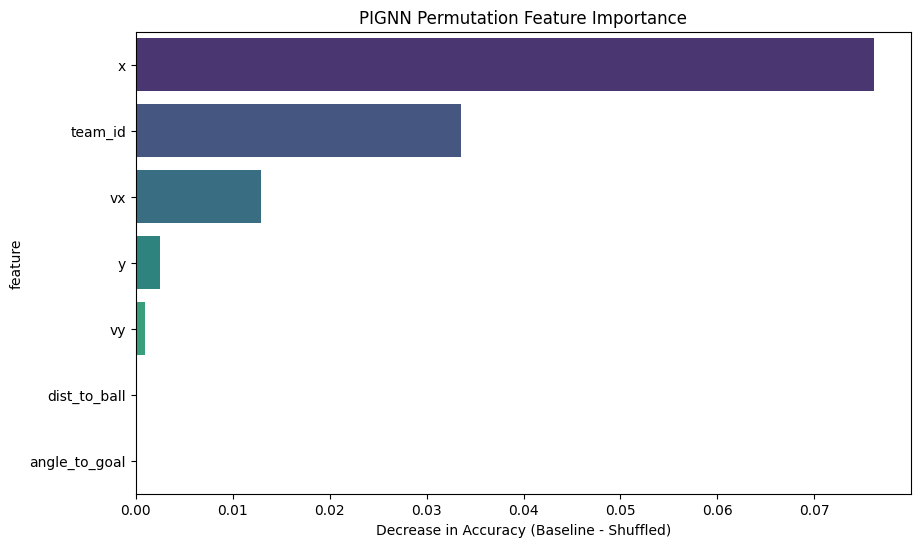

In [ ]:
import copy
import pandas as pd
import seaborn as sns

def run_pignn_pfi(model, data_list, device):
    model.eval()
    # 1. ベースライン精度の計算 (F1スコアなどを指標にする)
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in data_list:
            d_gpu = data.to(device)
            out = model(d_gpu)
            y_true.append(d_gpu.y.item())
            y_pred.append(out.argmax(dim=1).item())

    # 簡単のため、今回はAccuracy（正解率）の低下幅で計算します
    from sklearn.metrics import accuracy_score
    baseline_acc = accuracy_score(y_true, y_pred)
    print(f"✅ Baseline Accuracy: {baseline_acc:.4f}")

    # 特徴量の名前リスト (in_channels=7 の内訳)
    feature_names = ['x', 'y', 'vx', 'vy', 'dist_to_ball', 'angle_to_goal', 'team_id']
    results = []

    for feat_idx in range(len(feature_names)):
        shuffled_preds = []

        # 2. 特定の特徴量をシャッフルして精度を再測定
        for data in data_list:
            # データのコピーを作成
            data_shuffled = copy.deepcopy(data).to(device)

            # ノード単位で該当する特徴量だけをシャッフル
            perm = torch.randperm(data_shuffled.x.size(0))
            data_shuffled.x[:, feat_idx] = data_shuffled.x[perm, feat_idx]

            with torch.no_grad():
                out = model(data_shuffled)
                shuffled_preds.append(out.argmax(dim=1).item())

        shuffled_acc = accuracy_score(y_true, shuffled_preds)
        importance = baseline_acc - shuffled_acc # 低下幅が重要度
        results.append({'feature': feature_names[feat_idx], 'importance': importance})
        print(f"🔥 {feature_names[feat_idx]:<15} | Importance: {importance:.4f}")

    # 3. 結果の可視化
    df_pfi = pd.DataFrame(results).sort_values(by='importance', ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=df_pfi, palette='viridis')
    plt.title("PIGNN Permutation Feature Importance")
    plt.xlabel("Decrease in Accuracy (Baseline - Shuffled)")
    plt.show()
    return df_pfi

# 実行
df_pfi_results = run_pignn_pfi(model_viz, all_data_list, device)

⏳ GNNExplainer実行中（物理ゲート全情報を使用）...
✅ 計算完了。


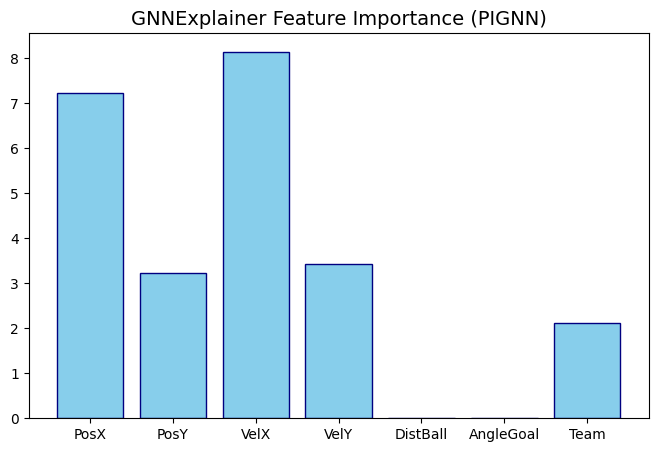

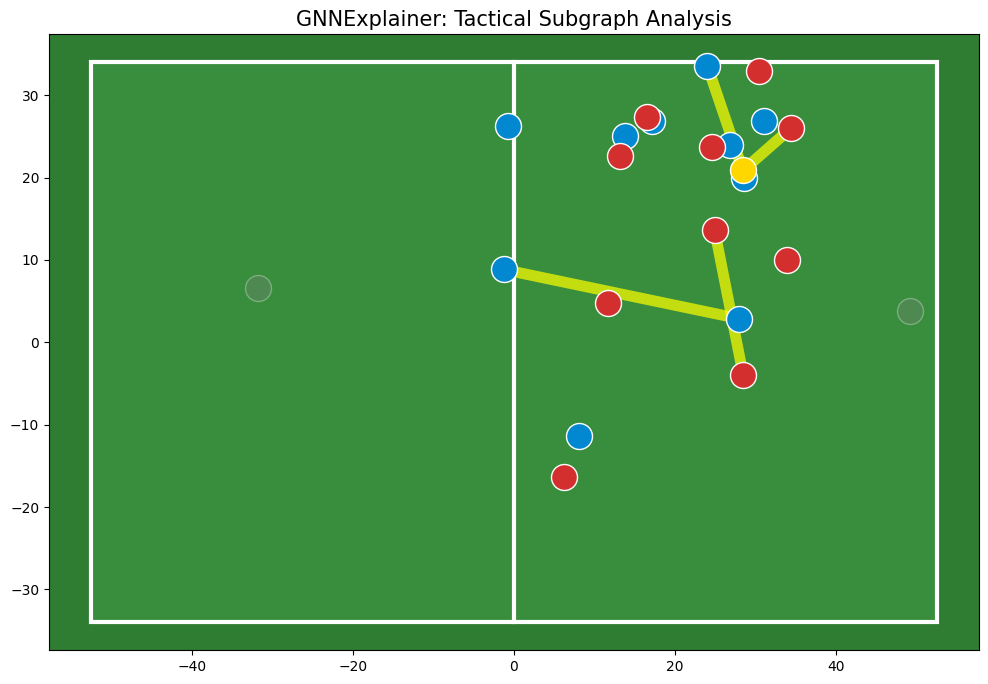

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch_geometric.explain import Explainer, GNNExplainer

# ==========================================
# 1. 物理整合性完全対応ラッパークラス
# ==========================================
class PIGNNExplainerWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x, edge_index, **kwargs):
        # 実行時に AttributeError が出ないよう、モデルが必要とする全ての属性を持つ
        # 擬似Dataオブジェクトを作成します。
        class DataContainer:
            pass

        data = DataContainer()
        data.x = x
        data.edge_index = edge_index
        data.batch = kwargs.get('batch', torch.zeros(x.size(0), dtype=torch.long, device=x.device))

        # PIGNNClassifierが必要とする3つの時系列座標
        data.pos = kwargs.get('pos', None)
        data.prev_pos = kwargs.get('prev_pos', None)
        # エラーの原因：pprev_posが不足していたので、kwargsまたはdata_singleから取得
        data.pprev_pos = kwargs.get('pprev_pos', None)

        # モデルに投げる
        return self.model(data)

# ラップしたモデルを作成
wrapped_model = PIGNNExplainerWrapper(model_viz)

# ==========================================
# 2. Explainerの設定
# ==========================================
explainer = Explainer(
    model=wrapped_model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='graph',
        return_type='log_probs',
    ),
)

# データの準備（pprev_posも含めてto(device)する）
data_single = viz_success_case.to(device)

# 実行
print("⏳ GNNExplainer実行中（物理ゲート全情報を使用）...")
explanation = explainer(
    x=data_single.x,
    edge_index=data_single.edge_index,
    batch=torch.zeros(data_single.x.size(0), dtype=torch.long, device=device),
    pos=data_single.pos,
    prev_pos=data_single.prev_pos,
    pprev_pos=getattr(data_single, 'pprev_pos', None) # 属性が存在する場合のみ渡す
)
print("✅ 計算完了。")

# --- 棒グラフ表示 ---
labels = ['PosX', 'PosY', 'VelX', 'VelY', 'DistBall', 'AngleGoal', 'Team']
feat_importance = explanation.node_mask.abs().sum(dim=0).cpu().numpy()
plt.figure(figsize=(8, 5))
plt.bar(labels, feat_importance, color='skyblue', edgecolor='navy')
plt.title("GNNExplainer Feature Importance (PIGNN)", fontsize=14)
plt.show()

# --- ピッチ上可視化 ---
def visualize_tactical_gnn_final(explanation, data):
    pos = data.pos.cpu().numpy()
    edge_index = data.edge_index.cpu().numpy()
    edge_mask = explanation.edge_mask.cpu().numpy()
    team_ids = data.x[:, 6].cpu().numpy()

    pos_x, pos_y = pos[:, 0] * 52.5, pos[:, 1] * 34.0

    # GK特定
    player_idx = np.where(team_ids != 2.0)[0]
    gk_idx = [player_idx[np.argmin(pos[player_idx, 0])], player_idx[np.argmax(pos[player_idx, 0])]]

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_facecolor('#2e7d32')
    ax.add_patch(patches.Rectangle((-52.5, -34), 105, 68, fill=True, color='#388e3c', zorder=0))
    ax.add_patch(patches.Rectangle((-52.5, -34), 105, 68, fill=False, color='white', lw=3))
    ax.plot([0, 0], [-34, 34], color='white', lw=3)

    # 重要エッジ (上位2%)
    threshold = np.percentile(edge_mask, 98)
    for i in range(len(edge_mask)):
        src, dst = edge_index[0, i], edge_index[1, i]
        if src in gk_idx or dst in gk_idx: continue
        if edge_mask[i] >= threshold:
            ax.plot([pos_x[src], pos_x[dst]], [pos_y[src], pos_y[dst]],
                    color='yellow', alpha=0.7, lw=2 + 6*(edge_mask[i]/edge_mask.max()), zorder=2)

    # 選手・ボール
    for i in range(len(pos)):
        color = 'gray' if i in gk_idx else ('gold' if team_ids[i]==2.0 else ('#0288d1' if team_ids[i]==0.0 else '#d32f2f'))
        ax.scatter(pos_x[i], pos_y[i], c=color, s=350, edgecolors='white', zorder=3, alpha=0.3 if i in gk_idx else 1.0)
    plt.title("GNNExplainer: Tactical Subgraph Analysis", fontsize=15)
    plt.show()

visualize_tactical_gnn_final(explanation, data_single)

⏳ GNNExplainer実行中（物理ゲート全情報を使用）...
✅ 計算完了。


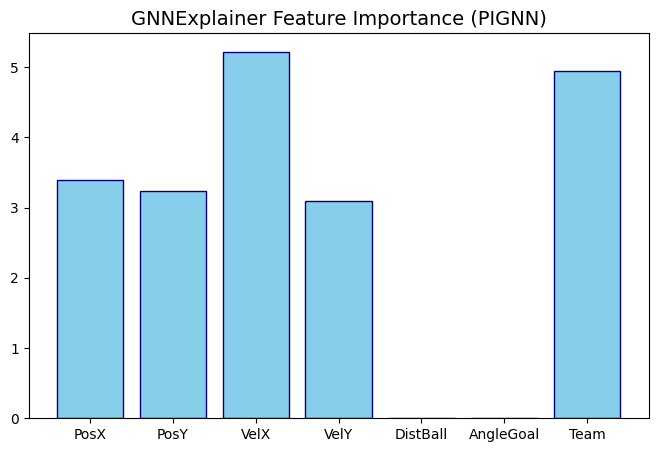

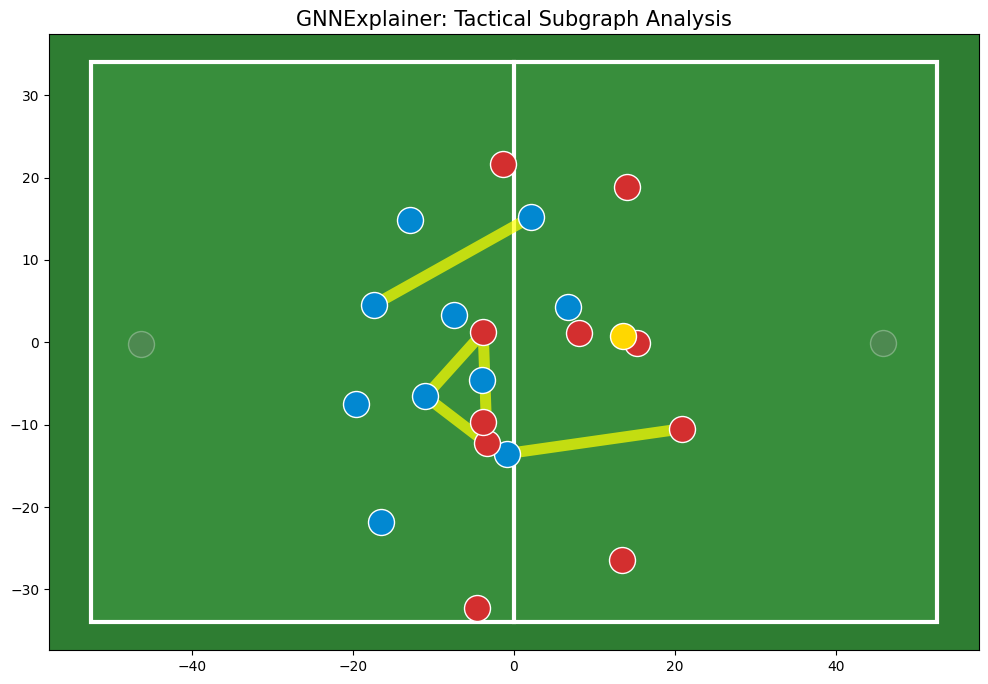

In [ ]:
# データの準備（pprev_posも含めてto(device)する）
data_single = viz_failure_case.to(device)

# 実行
print("⏳ GNNExplainer実行中（物理ゲート全情報を使用）...")
explanation = explainer(
    x=data_single.x,
    edge_index=data_single.edge_index,
    batch=torch.zeros(data_single.x.size(0), dtype=torch.long, device=device),
    pos=data_single.pos,
    prev_pos=data_single.prev_pos,
    pprev_pos=getattr(data_single, 'pprev_pos', None) # 属性が存在する場合のみ渡す
)
print("✅ 計算完了。")

# --- 棒グラフ表示 ---
labels = ['PosX', 'PosY', 'VelX', 'VelY', 'DistBall', 'AngleGoal', 'Team']
feat_importance = explanation.node_mask.abs().sum(dim=0).cpu().numpy()
plt.figure(figsize=(8, 5))
plt.bar(labels, feat_importance, color='skyblue', edgecolor='navy')
plt.title("GNNExplainer Feature Importance (PIGNN)", fontsize=14)
plt.show()

# --- ピッチ上可視化 ---
def visualize_tactical_gnn_final(explanation, data):
    pos = data.pos.cpu().numpy()
    edge_index = data.edge_index.cpu().numpy()
    edge_mask = explanation.edge_mask.cpu().numpy()
    team_ids = data.x[:, 6].cpu().numpy()

    pos_x, pos_y = pos[:, 0] * 52.5, pos[:, 1] * 34.0

    # GK特定
    player_idx = np.where(team_ids != 2.0)[0]
    gk_idx = [player_idx[np.argmin(pos[player_idx, 0])], player_idx[np.argmax(pos[player_idx, 0])]]

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_facecolor('#2e7d32')
    ax.add_patch(patches.Rectangle((-52.5, -34), 105, 68, fill=True, color='#388e3c', zorder=0))
    ax.add_patch(patches.Rectangle((-52.5, -34), 105, 68, fill=False, color='white', lw=3))
    ax.plot([0, 0], [-34, 34], color='white', lw=3)

    # 重要エッジ (上位2%)
    threshold = np.percentile(edge_mask, 98)
    for i in range(len(edge_mask)):
        src, dst = edge_index[0, i], edge_index[1, i]
        if src in gk_idx or dst in gk_idx: continue
        if edge_mask[i] >= threshold:
            ax.plot([pos_x[src], pos_x[dst]], [pos_y[src], pos_y[dst]],
                    color='yellow', alpha=0.7, lw=2 + 6*(edge_mask[i]/edge_mask.max()), zorder=2)

    # 選手・ボール
    for i in range(len(pos)):
        color = 'gray' if i in gk_idx else ('gold' if team_ids[i]==2.0 else ('#0288d1' if team_ids[i]==0.0 else '#d32f2f'))
        ax.scatter(pos_x[i], pos_y[i], c=color, s=350, edgecolors='white', zorder=3, alpha=0.3 if i in gk_idx else 1.0)
    plt.title("GNNExplainer: Tactical Subgraph Analysis", fontsize=15)
    plt.show()

visualize_tactical_gnn_final(explanation, data_single)

1. アテンション係数（Attention Coefficient）GAT（Graph Attention Network）レイヤー内部で計算される、ノード間の相対的な重要度です。数式ノード $i$ からノード $j$ へのアテンション係数 $e_{ij}$ は、以下のように計算されます。$$e_{ij} = a( \mathbf{W}\vec{h}_i, \mathbf{W}\vec{h}_j \cdot \text{Gate}(\Delta \text{Phys}))$$ここで、$\text{Gate}(\Delta \text{Phys})$ があなたの導入した物理整合性ゲートです。これにより、物理的に矛盾するエッジの係数が強制的にゼロに近づけられます。これをソフトマックス関数で正規化したものが、可視化に使った $\alpha_{ij}$ です。$$\alpha_{ij} = \frac{\exp(\text{LeakyReLU}(e_{ij}))}{\sum_{k \in \mathcal{N}_i} \exp(\text{LeakyReLU}(e_{ik}))}$$性質意味: メッセージパッシング（情報伝達）の「通りやすさ」。図の見方: 線が引かれているところは「情報をやり取りした」過程を示します。計算プロセスの可視化です。\n
2. GNNExplainer予測結果 $y$ を導き出すために、どの入力特徴量 $X$ とグラフ構造（隣接行列 $A$）が不可欠だったかを最適化によって逆算します。数式GNNExplainerは、元の予測結果との相互情報量（Mutual Information）を最大化する「マスク（$M$）」を学習します。$$\max_{M} MI(Y, (A \odot \sigma(M), X)) = H(Y) - H(Y \mid A \odot \sigma(M), X)$$$A \odot \sigma(M)$: エッジに対するマスク（どのパスが重要か）。$X \odot \sigma(F)$: 特徴量に対するマスク（どの変数が重要か）。性質意味: 予測結果を維持するために「削ぎ落とせない最小の根拠」。図の見方: 線が残っているところは「これがなければ予測が覆る」決定的な要因（エビデンス）を示します。\n
3. PFI (Permutation Feature Importance)モデルを「ブラックボックス」として扱い、入力データの特定の列を破壊した際の影響度を測定します。数式ある特徴量 $f$ の重要度 $I_f$ は、元の予測精度 $Acc_{base}$ と、特徴量 $f$ をシャッフルした後の精度 $Acc_{perm}$ の差で定義されます。$$I_f = Acc_{base} - \frac{1}{K} \sum_{k=1}^K Acc_{perm, k}$$（$K$ はシャッフルを繰り返す回数）性質意味: モデル全体がその変数（例：VelX）にどれだけ依存しているかの「統計的依存度」。図の見方: 棒グラフが高いほど、その変数が「モデルの思考の基礎」であることを示します。

わかりやすくまとめると…

アテンション:**順伝播（Forward）**の中間値「計算中にどこを通ったか」というプロセス\n
GNNExplainer:**逆伝播（Optimization）**による近似「なぜその結論になったか」という論理的根拠\n

PFI**入力破壊（Perturbation）**による感度分析「その変数がどれだけ重要か」という統計的依存度